# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop

from os import getcwd
from absl import logging
logging.set_verbosity(logging.ERROR)

print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.10.0
• GPU Device Found.


## Image Augmentation (v2)

In [2]:
target_size = (224,224)

# Data Directory
data_dir = "data"

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        data_dir + "/train",  # This is the source directory for training images
        target_size=target_size,  # All images will be resized to 150x150
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='sparse')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        data_dir + "/val",
        target_size=target_size,
        batch_size=10,
        class_mode='sparse',
        shuffle=False
        )

test_generator = test_datagen.flow_from_directory(
        data_dir + "/test",
        target_size=target_size,
        batch_size=10,
        class_mode='sparse',
        shuffle=False
        )

Found 14000 images belonging to 28 classes.
Found 397 images belonging to 28 classes.
Found 409 images belonging to 28 classes.


# Modelling

In [3]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
def create_pre_trained_model():
  """
  Initializes an InceptionV3 model.

  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file

  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """
  pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                  include_top = False)

  for layer in pre_trained_model.layers:
    layer.trainable = True

  return pre_trained_model

In [5]:
pre_trained_model = create_pre_trained_model()

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [6]:
def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model

  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

  Returns:
    last_output: output of the model's last layer
  """
  last_desired_layer = pre_trained_model.get_layer('mixed9')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [7]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 5, 5, 2048)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 2048), dtype=tf.float32, name=None), name='mixed9/concat:0', description="created by layer 'mixed9'")


In [8]:
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model

  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

  Returns:
    model: the combined model
  """
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(32, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.3)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(28, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = Adam(learning_rate=1e-4),
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])


  return model

In [9]:
model = create_final_model(pre_trained_model, last_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

In [10]:
# Define the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=50, 
    verbose=1, 
    restore_best_weights=True
    )

# Train your model
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])

Epoch 1/100
1400/1400 [==============================] - ETA: 0s - loss: 1.1252 - accuracy: 0.6931

C:\Users\Destiny\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1400/1400 [==============================] - 95s 62ms/step - loss: 1.1252 - accuracy: 0.6931 - val_loss: 1.1635 - val_accuracy: 0.7355
Epoch 2/100
1400/1400 [==============================] - 84s 60ms/step - loss: 0.3183 - accuracy: 0.9140 - val_loss: 0.9161 - val_accuracy: 0.7733
Epoch 3/100
1400/1400 [==============================] - 84s 60ms/step - loss: 0.2124 - accuracy: 0.9421 - val_loss: 0.7532 - val_accuracy: 0.8615
Epoch 4/100
1400/1400 [==============================] - 84s 60ms/step - loss: 0.1793 - accuracy: 0.9494 - val_loss: 0.8756 - val_accuracy: 0.8665
Epoch 5/100
1400/1400 [==============================] - 84s 60ms/step - loss: 0.1604 - accuracy: 0.9560 - val_loss: 1.4259 - val_accuracy: 0.8237
Epoch 6/100
1400/1400 [==============================] - 84s 60ms/step - loss: 0.1371 - accuracy: 0.9646 - val_loss: 0.5931 - val_accuracy: 0.8791
Epoch 7/100
1400/1400 [==============================] - 84s 60ms/step - loss: 0.1325 - accuracy: 0.9661 - val_loss: 1.0434 - val_

1400/1400 [==============================] - 83s 59ms/step - loss: 0.0479 - accuracy: 0.9861 - val_loss: 0.8930 - val_accuracy: 0.8741
Epoch 57/100
1400/1400 [==============================] - 83s 60ms/step - loss: 0.0398 - accuracy: 0.9881 - val_loss: 1.3850 - val_accuracy: 0.8338
Epoch 58/100
1400/1400 [==============================] - 84s 60ms/step - loss: 0.0513 - accuracy: 0.9862 - val_loss: 1.0802 - val_accuracy: 0.8388
Epoch 59/100
1400/1400 [==============================] - 83s 60ms/step - loss: 0.0429 - accuracy: 0.9879 - val_loss: 1.0066 - val_accuracy: 0.8866
Epoch 60/100
1400/1400 [==============================] - 84s 60ms/step - loss: 0.0458 - accuracy: 0.9874 - val_loss: 0.9508 - val_accuracy: 0.8237
Epoch 61/100
1400/1400 [==============================] - 84s 60ms/step - loss: 0.0350 - accuracy: 0.9879 - val_loss: 0.8537 - val_accuracy: 0.8715
Epoch 62/100
1400/1400 [==============================] - 84s 60ms/step - loss: 0.0382 - accuracy: 0.9884 - val_loss: 1.6618 

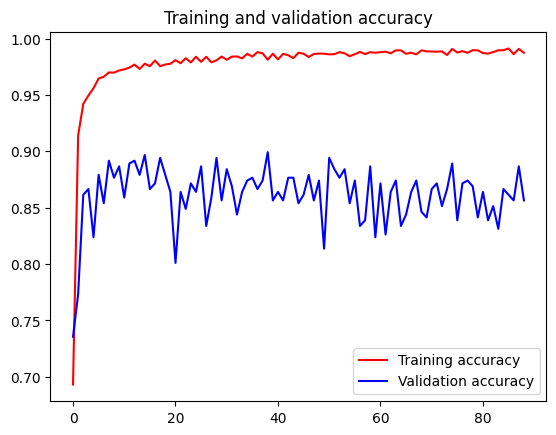

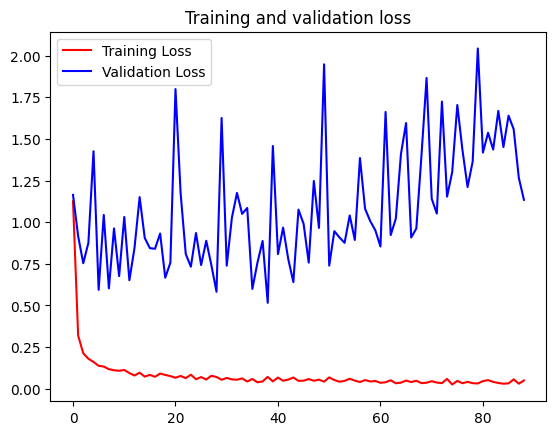

In [11]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

14/41 [=========>....................] - ETA: 1s

C:\Users\Destiny\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 [==============================] - 3s 63ms/step
Accuracy: 0.9242053789731052
Recall: 0.9242053789731052
Precision: 0.9337500678901398
F1-score: 0.9240726285639149


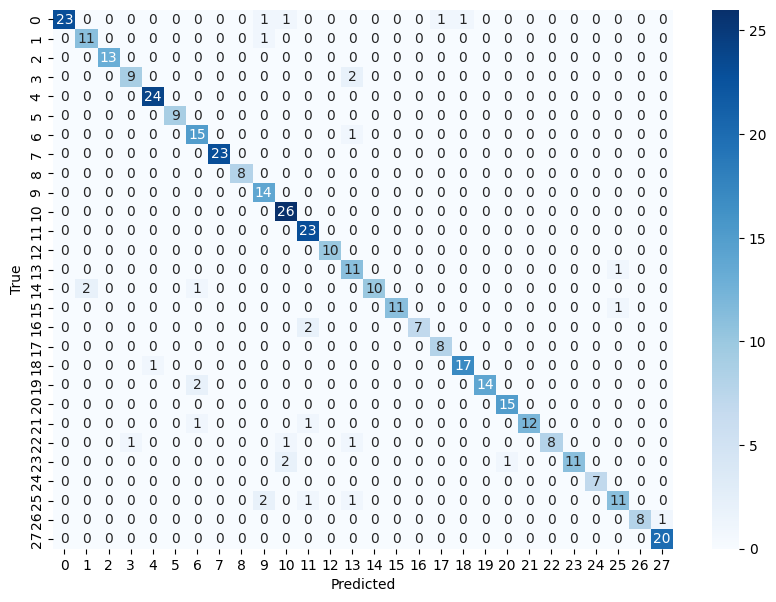

In [12]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the validation data and get predictions
test_labels = test_generator.classes
test_predictions = model.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_pred_classes)

# Calculate accuracy, recall, precision, and f1-score
accuracy = accuracy_score(test_labels, test_pred_classes)
recall = recall_score(test_labels, test_pred_classes, average='weighted')
precision = precision_score(test_labels, test_pred_classes, average='weighted')
f1 = f1_score(test_labels, test_pred_classes, average='weighted')

# Print the metrics
print('=============================')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1-score: {f1}')
print('=============================')

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Save Model to tflite

In [13]:
# Konverter model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('InceptionV3_model_v3.1.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model telah dikonversi dan disimpan sebagai InceptionV3_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\Destiny\AppData\Local\Temp\tmp7zhs9lzy\assets


INFO:tensorflow:Assets written to: C:\Users\Destiny\AppData\Local\Temp\tmp7zhs9lzy\assets


Model telah dikonversi dan disimpan sebagai InceptionV3_model.tflite


Save Model to json

In [ ]:
# # Assume `model` is your trained Keras model
# model_json = model.to_json()

# # Save the model architecture to a JSON file
# with open("InceptionV3_model_v3.1.json", "w") as json_file:
#     json_file.write(model_json)
    
# # Save the weights of the model to an HDF5 file
# model.save_weights("InceptionV3_weight_v3.1.h5")

Save Model to tfjs

In [15]:
# Assume `model` is your trained Keras model
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [16]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/15.2 MB ? eta -:--:--
     ---------------------------------------- 0.1/15.2 MB 3.3 MB/s eta 0:00:05
     - -------------------------------------- 0.4/15.2 MB 6.4 MB/s eta 0:00:03
     - -------------------------------------- 0.7/15.2 MB 6.7 MB/s eta 0:00:03
     --- ------------------------------------ 1.4/15.2 MB 10.1 MB/s eta 0:00:02
     ----- ---------------------------------- 2.1/15.2 MB 12.4 MB/s eta 0:00:02
     ------- -------------------------------- 2.9/15.2 MB 14.3 MB/s eta 0:00:01
     --------- ------------------------------ 3.7/15.2 MB 15.0 MB/s eta 0:00:01
     ------------ --------------------------- 4.6/15.2 MB 16.5 MB/s eta 0:00:01
     -------------- ------------------------- 5.6/15.2 MB 17.9 MB/s eta 0:00:01
     ----------------- ---------------------- 6.6/15.2 MB 19.2 MB/s eta 0:00:01
     -------------------- ------------------- 7.7/15.

ERROR: Exception:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\envs\tf\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\ProgramData\anaconda3\envs\tf\lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "C:\ProgramData\anaconda3\envs\tf\lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "C:\ProgramData\anaconda3\envs\tf\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
  File "C:\ProgramData\anaconda3\envs\tf\lib\http\client.py", line 466, in read
    s = self.fp.read(amt)
  File "C:\ProgramData\anaconda3\envs\tf\lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "C:\ProgramData\anaconda3\envs\tf\lib\ssl.py", line 1307, in recv_into
    return

In [17]:
# Assume `model` is your trained Keras model
model_json = model.to_json()

# Save the model architecture to a JSON file
with open("InceptionV3_model_v3.1.json", "w") as json_file:
    json_file.write(model_json)
    
# Save the weights of the model to an HDF5 file
model.save_weights("InceptionV3_weight_v3.1.h5")

In [18]:
# Simpan model sebagai file .h5
model.save('model.h5')

import tensorflow as tf
import pickle

# Muat model dari file .h5
loaded_model = tf.keras.models.load_model('model.h5')

# Simpan model ke file pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(loaded_model, file)

INFO:tensorflow:Assets written to: ram://f95f0b39-3f72-48ee-9b3e-6fecb3c2b3c8/assets


INFO:tensorflow:Assets written to: ram://f95f0b39-3f72-48ee-9b3e-6fecb3c2b3c8/assets
